# Emotional Drift Demo
This notebook walks through each step of the emotional drift pipeline on a short text sample, with explanations of what each step is doing and why.

## 1) Imports
We load the tools needed for tokenization, sentiment/subjectivity scoring, and plotting.

In [1]:
import re
from pathlib import Path

import nltk
import spacy
import matplotlib.pyplot as plt
import numpy as np
from nrclex import NRCLex
from textblob import TextBlob

nlp = spacy.load("en_core_web_sm")
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2) Sample text
We use a short, handwritten mini story so changes in emotion are easy to spot. This is just a demo for longer text like scripts or diaries.

In [2]:
sample_text = (
    """
    I was very happy and excited today.
    Life felt beautiful and full of hope.
    Suddenly I felt sad and lonely.
    I became anxious and scared.
    Everything seemed terrible.
    Then I met a friend and felt happy again.
    I was angry at first but later calm.
    """
 )
sample_text

'\n    I was very happy and excited today.\n    Life felt beautiful and full of hope.\n    Suddenly I felt sad and lonely.\n    I became anxious and scared.\n    Everything seemed terrible.\n    Then I met a friend and felt happy again.\n    I was angry at first but later calm.\n    '

## 3) Clean text
We normalize whitespace and remove unusual characters so the downstream models see a consistent input. This reduces noise that can hurt sentence splitting and lexicon matches.

In [3]:
def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9.,!? ]", "", text)
    return text

cleaned = clean_text(sample_text)
cleaned

' I was very happy and excited today. Life felt beautiful and full of hope. Suddenly I felt sad and lonely. I became anxious and scared. Everything seemed terrible. Then I met a friend and felt happy again. I was angry at first but later calm. '

## 4) Sentence segmentation
We split the text into sentences because drift is measured across time. Each sentence becomes a time step with its own scores.

In [4]:
def segment_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

sentences = segment_sentences(cleaned)
sentences

['I was very happy and excited today.',
 'Life felt beautiful and full of hope.',
 'Suddenly I felt sad and lonely.',
 'I became anxious and scared.',
 'Everything seemed terrible.',
 'Then I met a friend and felt happy again.',
 'I was angry at first but later calm.']

## 5) Sentiment and subjectivity
Sentiment captures positive/negative tone. Subjectivity captures how opinionated or personal the language is. Tracking both lets us distinguish emotional swings from factual narration.

In [5]:
def get_sentiment_scores(sentences):
    scores = []
    for sentence in sentences:
        blob = TextBlob(sentence)
        scores.append(blob.sentiment.polarity)
    return scores

def get_subjectivity_scores(sentences):
    scores = []
    for sentence in sentences:
        blob = TextBlob(sentence)
        scores.append(blob.sentiment.subjectivity)
    return scores

sentiment_scores = get_sentiment_scores(sentences)
subjectivity_scores = get_subjectivity_scores(sentences)
sentiment_scores, subjectivity_scores

([0.6875, 0.6, -0.19999999999999998, -0.25, -1.0, 0.8, 0.012500000000000011],
 [0.875, 0.775, 0.7333333333333334, 1.0, 1.0, 1.0, 0.5208333333333333])

## 6) Emotion categories
The NRC lexicon maps words to specific emotions (joy, anger, fear, etc.). We count these signals per sentence and normalize by sentence length to compare fairly.

In [6]:
EMOTION_CATEGORIES = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "sadness",
    "surprise",
    "trust",
]

def get_emotion_category_scores(sentences, emotions=None):
    if emotions is None:
        emotions = EMOTION_CATEGORIES
    scores = {emotion: [] for emotion in emotions}
    for sentence in sentences:
        lex = NRCLex(sentence)
        raw_scores = lex.raw_emotion_scores
        word_count = len(re.findall(r"[A-Za-z']+", sentence))
        denom = max(1, word_count)
        for emotion in emotions:
            scores[emotion].append(raw_scores.get(emotion, 0) / denom)
    return scores

emotion_scores = get_emotion_category_scores(sentences)
emotion_scores

{'anger': [0.0, 0.0, 0.16666666666666666, 0.0, 0.3333333333333333, 0.0, 0.125],
 'anticipation': [0.2857142857142857,
  0.14285714285714285,
  0.0,
  0.2,
  0.0,
  0.1111111111111111,
  0.0],
 'disgust': [0.0,
  0.0,
  0.16666666666666666,
  0.0,
  0.3333333333333333,
  0.0,
  0.125],
 'fear': [0.0, 0.0, 0.16666666666666666, 0.2, 0.3333333333333333, 0.0, 0.0],
 'joy': [0.2857142857142857,
  0.2857142857142857,
  0.0,
  0.0,
  0.0,
  0.2222222222222222,
  0.0],
 'sadness': [0.0, 0.0, 0.16666666666666666, 0.0, 0.3333333333333333, 0.0, 0.0],
 'surprise': [0.14285714285714285,
  0.14285714285714285,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'trust': [0.2857142857142857,
  0.14285714285714285,
  0.0,
  0.0,
  0.0,
  0.2222222222222222,
  0.0]}

In [7]:
# quick table
headers = ["Sentence", "Sentiment", "Subjectivity"] + [e.capitalize() for e in EMOTION_CATEGORIES]
rows = []
for i, sentence in enumerate(sentences, start=1):
    sentiment = sentiment_scores[i - 1]
    subjectivity = subjectivity_scores[i - 1]
    emotion_vals = [emotion_scores[e][i - 1] for e in EMOTION_CATEGORIES]
    rows.append([sentence, sentiment, subjectivity] + emotion_vals)

col_widths = [max(len(headers[0]), max(len(r[0]) for r in rows))]
for col in range(1, len(headers)):
    col_widths.append(max(len(headers[col]), 6))

def fmt_row(values):
    return " | ".join(
        str(values[i]).ljust(col_widths[i]) if i == 0 else f"{values[i]:.2f}".rjust(col_widths[i])
        for i in range(len(values))
    )

def fmt_header(values):
    return " | ".join(
        str(values[i]).ljust(col_widths[i])
        for i in range(len(values))
    )

print(fmt_header(headers))
print("-" * (sum(col_widths) + 3 * (len(col_widths) - 1)))
for row in rows:
    print(fmt_row(row))

Sentence                                  | Sentiment | Subjectivity | Anger  | Anticipation | Disgust | Fear   | Joy    | Sadness | Surprise | Trust 
------------------------------------------------------------------------------------------------------------------------------------------------------
I was very happy and excited today.       |      0.69 |         0.88 |   0.00 |         0.29 |    0.00 |   0.00 |   0.29 |    0.00 |     0.14 |   0.29
Life felt beautiful and full of hope.     |      0.60 |         0.78 |   0.00 |         0.14 |    0.00 |   0.00 |   0.29 |    0.00 |     0.14 |   0.14
Suddenly I felt sad and lonely.           |     -0.20 |         0.73 |   0.17 |         0.00 |    0.17 |   0.17 |   0.00 |    0.17 |     0.00 |   0.00
I became anxious and scared.              |     -0.25 |         1.00 |   0.00 |         0.20 |    0.00 |   0.20 |   0.00 |    0.00 |     0.00 |   0.00
Everything seemed terrible.               |     -1.00 |         1.00 |   0.33 |         0.00 |

## 7) Smoothing and shift detection
Raw scores can be noisy. A sliding window smooths short-term spikes into the overall trend. We also flag large jumps between adjacent sentences as potential emotional shifts.

In [8]:
def sliding_window_average(scores, window_size=3):
    smoothed = []
    for i in range(len(scores)):
        start = max(0, i - window_size + 1)
        window = scores[start:i+1]
        smoothed.append(np.mean(window))
    return smoothed

def detect_shifts(scores, threshold=0.5):
    shifts = []
    for i in range(1, len(scores)):
        if abs(scores[i] - scores[i-1]) > threshold:
            shifts.append(i)
    return shifts

smoothed_sentiment = sliding_window_average(sentiment_scores)
smoothed_subjectivity = sliding_window_average(subjectivity_scores)
shifts = detect_shifts(smoothed_sentiment)
smoothed_sentiment, smoothed_subjectivity, shifts

([np.float64(0.6875),
  np.float64(0.64375),
  np.float64(0.36250000000000004),
  np.float64(0.05000000000000001),
  np.float64(-0.48333333333333334),
  np.float64(-0.15),
  np.float64(-0.06249999999999998)],
 [np.float64(0.875),
  np.float64(0.825),
  np.float64(0.7944444444444444),
  np.float64(0.8361111111111111),
  np.float64(0.9111111111111111),
  np.float64(1.0),
  np.float64(0.8402777777777777)],
 [4])

## 8) Plots
We visualize the timelines so the drift is easy to see. Each plot shows how a signal evolves across sentences.

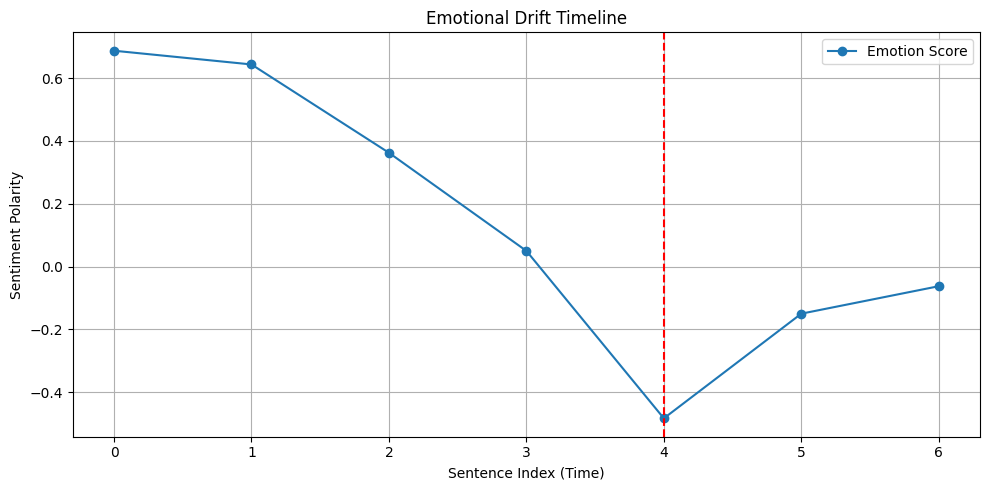

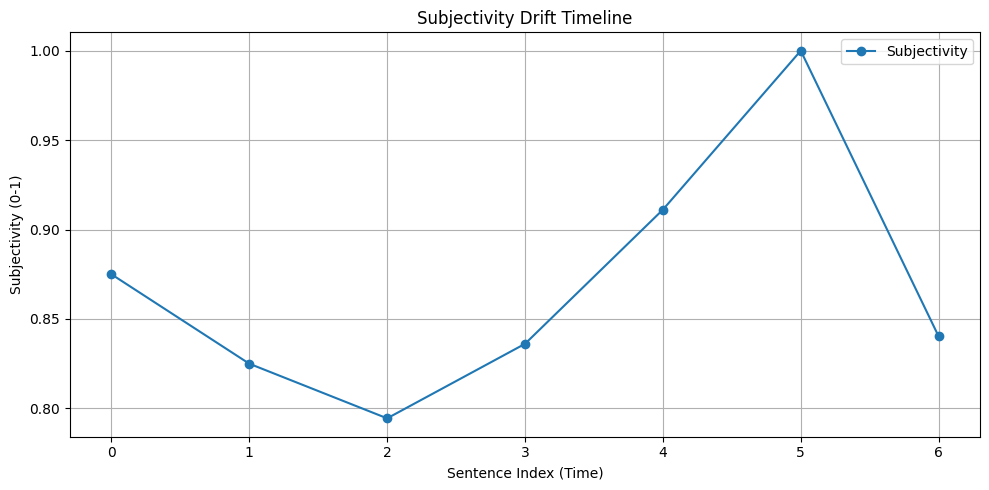

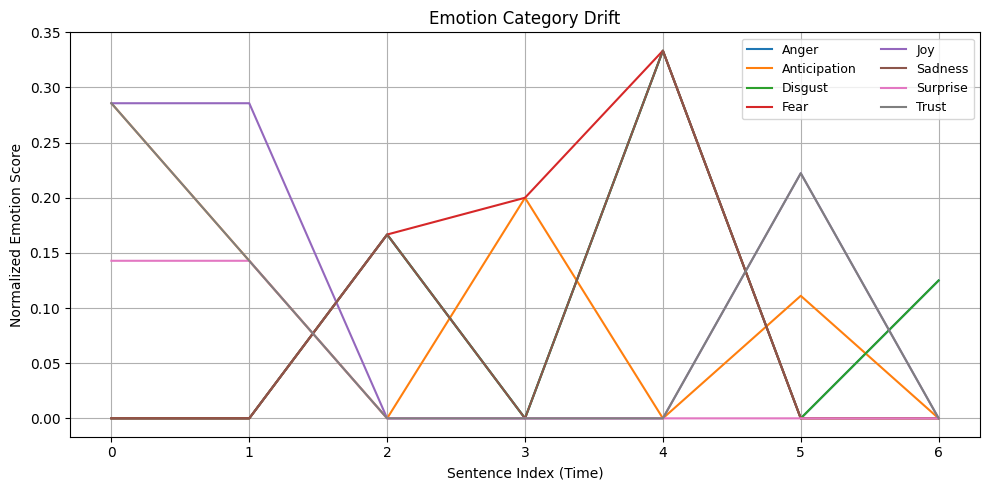

In [9]:
def plot_emotion_timeline(scores, shifts, output_dir="results", filename="emotional_drift_demo.png"):
    plt.figure(figsize=(10,5))
    plt.plot(scores, marker='o', label="Emotion Score")
    for shift in shifts:
        plt.axvline(x=shift, color='red', linestyle='--')
    plt.title("Emotional Drift Timeline")
    plt.xlabel("Sentence Index (Time)")
    plt.ylabel("Sentiment Polarity")
    plt.legend()
    plt.grid(True)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path / filename, dpi=150)
    plt.show()

def plot_subjectivity_timeline(scores, output_dir="results", filename="subjectivity_drift_demo.png"):
    plt.figure(figsize=(10,5))
    plt.plot(scores, marker='o', label="Subjectivity")
    plt.title("Subjectivity Drift Timeline")
    plt.xlabel("Sentence Index (Time)")
    plt.ylabel("Subjectivity (0-1)")
    plt.legend()
    plt.grid(True)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path / filename, dpi=150)
    plt.show()

def plot_emotion_categories(emotion_scores, output_dir="results", filename="emotion_categories_demo.png"):
    plt.figure(figsize=(10,5))
    for emotion, values in emotion_scores.items():
        plt.plot(values, label=emotion.capitalize())
    plt.title("Emotion Category Drift")
    plt.xlabel("Sentence Index (Time)")
    plt.ylabel("Normalized Emotion Score")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path / filename, dpi=150)
    plt.show()

plot_emotion_timeline(smoothed_sentiment, shifts)
plot_subjectivity_timeline(smoothed_subjectivity)
plot_emotion_categories(emotion_scores)